# STAT209 HW3

Seokjun Choi

## Problem 2

*Code blocks are Python scripts of this problem.*

*Executable stand-alone Python script: https://github.com/letsjdosth/GLM/blob/main/hw3q2.py*

*This code is depending on third-party packages*
- numpy
- matplotlib
and the another python module that I implemented,
- MCMC_Core *https://github.com/letsjdosth/GLM/blob/main/pyBayes/MCMC_Core.py* (Special thanks: Juhee & Richard, in STAT206B and STAT207)

*All scripts are tested in Python 3.10.5 64-bit, in Windows 10.*


I will use the same notation given in the problem.


For model settings and calculation results of posterior distributions, please see separately attached note.
In this document, I will use it without any additional explanation.

### Before starting...

1. Let me set the given data. In addition, I will define some functions that I will use later, including
    - log posterior kernels (without normalizing constant)
    - normal proposal sampler for MCMC
    - other functions for plotting and calculating some performance measures

    You may check that which function has which role, seeing the names of the functions. :D

2. We may apply various techniques, including
    - data augmentation for some models, for example, polya-gamma or Kolmogorov-Smirnov for logit models.
        - I skipped using them. For these two, I need to implement rejection samplers for each distribution, but honestly speaking, I need more time to read and understand the papers fully. One quick (and practical) approach is to use already implemented sampler by someone, but it seems meaningless as a purpose of 'my' study. So, let me leave them for my future work.
    - proposal distribution tuning in MCMC using data, for example, using inverse fisher information for multivariate normal proposal cov.
        - I remember that you suggested using the fisher information as a proposal cov. And it works very well, according to some guys in my cohort. But anyway my trials, it still good even if I just use diagonal covariance matrix with well-tuned values. So I skipped it.
    - MH-within-Gibbs
        - Oh.. it gets to be super slow. :D Maybe separating MCMC update for shape parameters (for example, $\alpha$ in the powered-logit link model) can or cannot help to converge, though.



In [10]:
# MCMC
from random import seed, normalvariate
from math import exp, log
from functools import partial
import matplotlib.pyplot as plt
import numpy as np

from pyBayes import MCMC_Core

seed(20221105)

# data
x_m_y = [
    (1.6907, 59, 6), 
    (1.7242, 60, 13),
    (1.7552, 62, 18),
    (1.7842, 56, 28),
    (1.8113, 63, 52),
    (1.8369, 59, 53),
    (1.8610, 62, 61),
    (1.8839, 60, 60)
]



# all MCMC settings
def symmetric_proposal_placeholder(from_smpl, to_smpl):
    #for log_proposal
    return 0

def normal_proposal_sampler(from_smpl, proposal_sigma_vec):
    return [normalvariate(x, proposal_sigma_vec[i]) for i,x in enumerate(from_smpl)]
    

def cloglog_posterior_with_flat_prior(beta, data):
    log_post = 0
    for (x, m, y) in data:
        nu = beta[0] + beta[1]*x
        log_post += (y*log(1-exp(-exp(nu))) + (m-y)*(-exp(nu)))
    return log_post

def cloglog_posterior_with_normal_prior(beta, data, sigma1, sigma2):
    log_post = cloglog_posterior_with_flat_prior(beta, data)
    log_post += (-0.5*beta[0]**2/(sigma1**2) - 0.5*beta[1]**2/(sigma2**2))
    return log_post

def logit_posterior_with_flat_prior(beta, data):
    log_post = 0
    for (x, m, y) in data:
        nu = beta[0] + beta[1]*x
        log_post += (y*nu - m*log(1+exp(nu)))
    return log_post

def powered_logit_posterior_with_normal_prior(beta_lambda, data, sigma1, sigma2, sigma_lambda):
    # beta_lambda=[beta1, beta2, lambda]
    log_post = 0
    e_lam = exp(beta_lambda[2])
    for (x, m, y) in data:
        nu = beta_lambda[0] + beta_lambda[1]*x
        try:
            log_post += (y*e_lam*nu - y*e_lam*log(1+exp(nu)) + (m-y)*log(1-(exp(nu)/(1+exp(nu)))**e_lam))
        except ValueError:
            if (m-y) == 0:
                log_post += (y*e_lam*nu - y*e_lam*log(1+exp(nu)))
            else:
                raise ValueError("check it", m-y, beta_lambda[2], e_lam, 1-(exp(nu)/(1+exp(nu)))**e_lam)
    log_post += 0.5*(-beta_lambda[0]**2/sigma1**2 - beta_lambda[1]**2/sigma2**2 - beta_lambda[2]/sigma_lambda**2)
    return log_post



# other utilities
def pi_plot(posterior_samples, link_func): #depend on x_m_y
    x_grid = np.arange(1.6, 1.9, 0.005)
    lwr = []
    med = []
    upr = []
    avg = []
    for x in x_grid:
        pi_samples_at_x = [link_func(x, params) for params in posterior_samples]
        lwr.append(float(np.quantile(pi_samples_at_x, 0.025)))
        med.append(float(np.quantile(pi_samples_at_x, 0.5)))
        upr.append(float(np.quantile(pi_samples_at_x, 0.975)))
        avg.append(float(np.mean(pi_samples_at_x)))

    plt.ylim([0, 1.05])
    plt.plot(x_grid, avg, color="black")
    plt.plot(x_grid, med, color="red")
    plt.plot(x_grid, lwr, color="grey")
    plt.plot(x_grid, upr, color="grey")
    plt.plot([x[0] for x in x_m_y], [x[2]/x[1] for x in x_m_y], marker="o")
    plt.show()

def bayesian_residual_plot(posterior_samples, link_func): #depend on x_m_y
    x_grid = [x[0] for x in x_m_y]
    boxplot_frame = []
    for (x, m, y) in x_m_y:
        obs_pi = y/m
        res_samples_at_x = [link_func(x, params)-obs_pi for params in posterior_samples]
        boxplot_frame.append(res_samples_at_x)

    plt.boxplot(np.transpose(boxplot_frame), labels=x_grid)
    plt.axhline(0)
    plt.show()

def loss_L_measure(posterior_samples, link_func, k): #depend on x_m_y
    loss = 0
    for (x, m, y) in x_m_y:
        pi_samples_at_x = [link_func(x, params) for params in posterior_samples]
        rng = np.random.default_rng()
        y_predictive_samples_at_x = [rng.binomial(m, pi) for pi in pi_samples_at_x]
        predictive_var_at_x = np.var(y_predictive_samples_at_x)
        predictive_mean_at_x = np.mean(y_predictive_samples_at_x)
        loss += (predictive_var_at_x + (k/(k+1))*(y-predictive_mean_at_x)**2)
    return loss


### 2-(a) Complementary log-log link model

To begin with, let me use a flat prior, $p(\beta_1, \beta_2) \propto 1$.

estimated running time:  0.0 min  1.9941329956054688 sec
iteration 20000 / 200000
iteration 40000 / 200000
iteration 60000 / 200000
iteration 80000 / 200000
iteration 100000 / 200000
iteration 120000 / 200000
iteration 140000 / 200000
iteration 160000 / 200000
iteration 180000 / 200000
iteration 200000 / 200000  done! (elapsed time for execution:  0.0 min  2.9368414878845215 sec)
acceptance rate:  0.0139


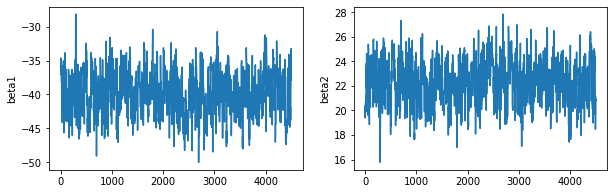

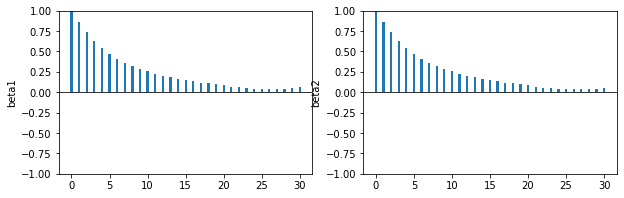

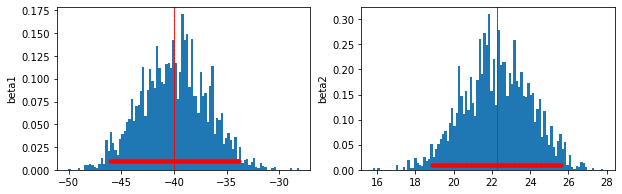

param 		 mean 	 var 	 95%CI
beta1 		 -39.977 	 9.952 	 [-46.047, -33.855]
beta2 		 22.265 	 3.066 	 [18.87, 25.593]


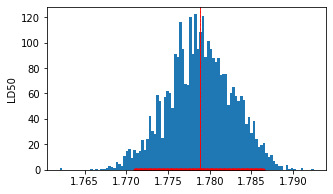

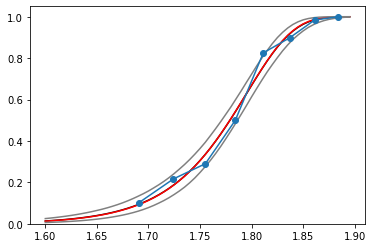

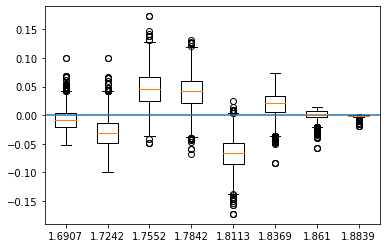

cloglog_flat L:  104.67639262711381


In [11]:
##2a
def cloglog_link(x, params):
    # params: [beta1, beta2]
    nu = params[0]+params[1]*x
    return 1-exp(-exp(nu))

cloglog_flat_initial = [0,0]
cloglog_flat_inst = MCMC_Core.MCMC_MH(
                partial(cloglog_posterior_with_flat_prior, data=x_m_y),
                symmetric_proposal_placeholder,
                partial(normal_proposal_sampler, proposal_sigma_vec=[3, 3]),
                cloglog_flat_initial)
cloglog_flat_inst.generate_samples(200000, print_iter_cycle=20000)
cloglog_flat_diag = MCMC_Core.MCMC_Diag()
cloglog_flat_diag.set_mc_sample_from_MCMC_instance(cloglog_flat_inst)
cloglog_flat_diag.set_variable_names(["beta1", "beta2"])
cloglog_flat_diag.burnin(20000)
cloglog_flat_diag.thinning(40)
cloglog_flat_diag.show_traceplot((1,2))
cloglog_flat_diag.show_acf(30, (1,2))
cloglog_flat_diag.show_hist((1,2))
cloglog_flat_diag.print_summaries(3)

cloglog_flat_LD50_samples = [[(log(-log(0.5))-x[0])/x[1]] for x in cloglog_flat_diag.MC_sample]
cloglog_flat_LD50_diag = MCMC_Core.MCMC_Diag()
cloglog_flat_LD50_diag.set_mc_samples_from_list(cloglog_flat_LD50_samples)
cloglog_flat_LD50_diag.set_variable_names(["LD50"])
cloglog_flat_LD50_diag.show_hist((1,1))

pi_plot(cloglog_flat_diag.MC_sample, cloglog_link)
bayesian_residual_plot(cloglog_flat_diag.MC_sample, cloglog_link)
print("cloglog_flat L: ", loss_L_measure(cloglog_flat_diag.MC_sample, cloglog_link, 10)) #105.81742676883584



Plots are:
- traceplot of all parameters (please see y-label) of MCMC chain
- ACF plots of all parameters (please see y-label) in the generated MCMC samples
- Histograms (blue), posterior mean(red vertical line), median (red dotted line), and 95% centered posterior credible interval (red horizontal line) for all parameters (please see y-label)
- the distribution of LD50 (its derivation: please see the attached note)
- $\pi$ verses log_dose plot, indicating posterior means (red curve), 95% centered posterior credible intervals (two gray curves), and observed $y/m$(blue dots and line.)
- Bayesian residual box-plot at each data point, using $\pi$ samples (Caution: the horizontal axis is sorted by the data index $i$, not x value itself.)

The table output in the middle is posterior summary (Sorry for bad tab setting. The column doesn't fit.)
The last line output is 'quadratic L measure' of the model, using posterior predictive samples, with $k=10$.

It seems that the chain converges well.
All fitting results seems to make sense. All observed ratios are in 95% CI in the $\pi$ vs log_dose plot.
All residuals are close to 0, covering zero within each whisker of the boxplot.


Next, I will use normal prior, $[\beta_1, \beta_2] \sim N_2([0, 0], diag(10^2, 10^2))$

estimated running time:  0.0 min  3.9882659912109375 sec
iteration 20000 / 200000
iteration 40000 / 200000
iteration 60000 / 200000
iteration 80000 / 200000
iteration 100000 / 200000
iteration 120000 / 200000
iteration 140000 / 200000
iteration 160000 / 200000
iteration 180000 / 200000
iteration 200000 / 200000  done! (elapsed time for execution:  0.0 min  3.6192665100097656 sec)
acceptance rate:  0.0131


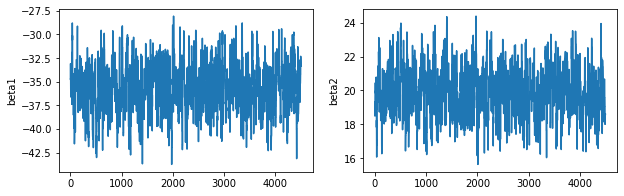

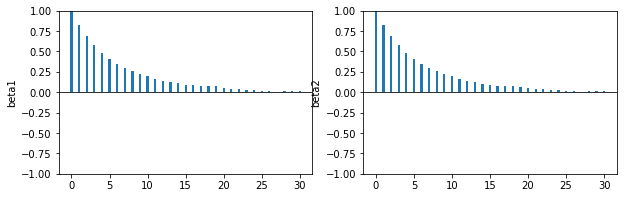

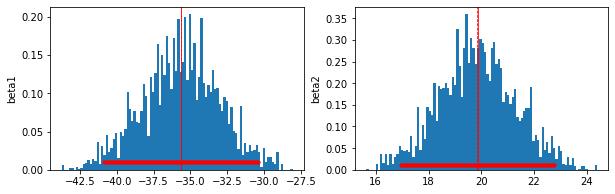

param 		 mean 	 var 	 95%CI
beta1 		 -35.652 	 6.846 	 [-40.851, -30.431]
beta2 		 19.863 	 2.106 	 [16.976, 22.767]


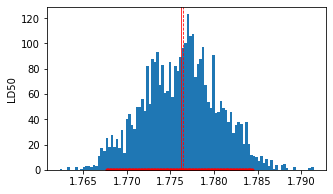

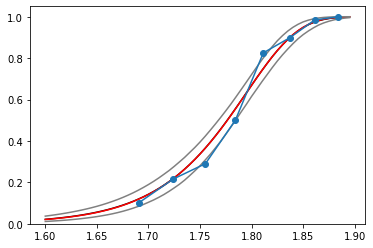

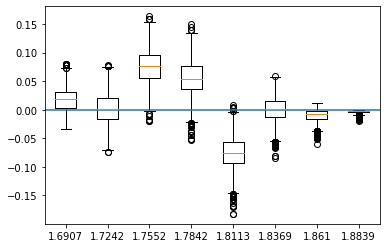

cloglog_normal L:  129.0531856926213


In [12]:

cloglog_normal_initial = [0,0]
cloglog_normal_initial_inst = MCMC_Core.MCMC_MH(
                partial(cloglog_posterior_with_normal_prior, data=x_m_y, sigma1=10, sigma2=10),
                symmetric_proposal_placeholder,
                partial(normal_proposal_sampler, proposal_sigma_vec=[3, 3]),
                cloglog_normal_initial)
cloglog_normal_initial_inst.generate_samples(200000, print_iter_cycle=20000)
cloglog_normal_diag = MCMC_Core.MCMC_Diag()
cloglog_normal_diag.set_mc_sample_from_MCMC_instance(cloglog_normal_initial_inst)
cloglog_normal_diag.set_variable_names(["beta1", "beta2"])
cloglog_normal_diag.burnin(20000)
cloglog_normal_diag.thinning(40)
cloglog_normal_diag.show_traceplot((1,2))
cloglog_normal_diag.show_acf(30, (1,2))
cloglog_normal_diag.show_hist((1,2))
cloglog_normal_diag.print_summaries(3)

cloglog_normal_LD50_samples = [[(log(-log(0.5))-x[0])/x[1]] for x in cloglog_normal_diag.MC_sample]
cloglog_normal_LD50_diag = MCMC_Core.MCMC_Diag()
cloglog_normal_LD50_diag.set_mc_samples_from_list(cloglog_normal_LD50_samples)
cloglog_normal_LD50_diag.set_variable_names(["LD50"])
cloglog_normal_LD50_diag.show_hist((1,1))

pi_plot(cloglog_normal_diag.MC_sample, cloglog_link)
bayesian_residual_plot(cloglog_normal_diag.MC_sample, cloglog_link)
print("cloglog_normal L: ", loss_L_measure(cloglog_normal_diag.MC_sample, cloglog_link, 10)) #129.2217430392814



Here are the same output-combination with above.

Fitting gets a little worse than flat-prior model.
The posterior means seems almost the same, but the estimates of uncertainty got smaller compared to flat-prior model.
This is natural result for normal prior with non-infinite variance, but it would better that 95% credible interval or longer whiskers in the residual plot get wider.
Not only that, we can observe that the 'L' measure gets higher here than at the flat prior model.

However, generally, I cannot find very significant difference between the fit with the flat prior and with the normal prior.
This is because I put vague normal prior onto parameters.
If I put more informative prior, the result would have change more.

### 2-(b) Logit link model

Here, I use the flat prior $p(\beta_1, \beta_2) \propto 1$ again.

estimated running time:  0.0 min  1.9936561584472656 sec
iteration 20000 / 200000
iteration 40000 / 200000
iteration 60000 / 200000
iteration 80000 / 200000
iteration 100000 / 200000
iteration 120000 / 200000
iteration 140000 / 200000
iteration 160000 / 200000
iteration 180000 / 200000
iteration 200000 / 200000  done! (elapsed time for execution:  0.0 min  2.2230260372161865 sec)
acceptance rate:  0.0255


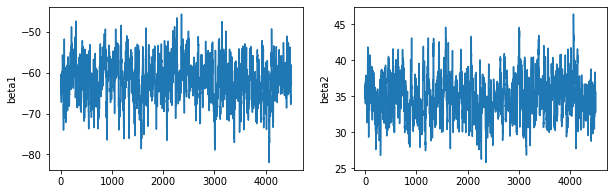

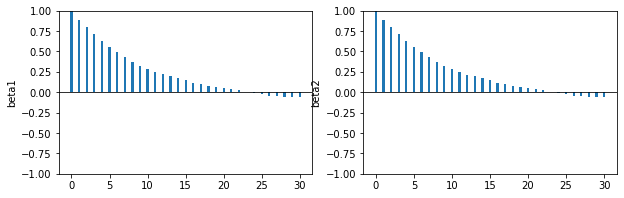

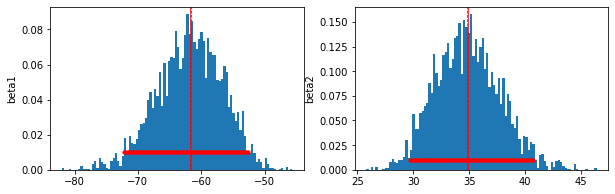

param 		 mean 	 var 	 95%CI
beta1 		 -61.82 	 26.672 	 [-72.161, -52.624]
beta2 		 34.89 	 8.424 	 [29.72, 40.72]


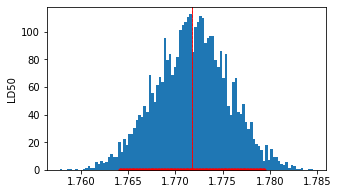

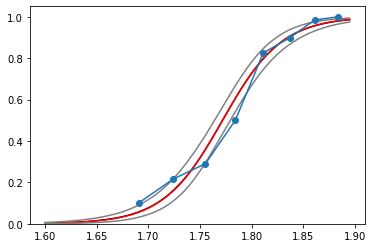

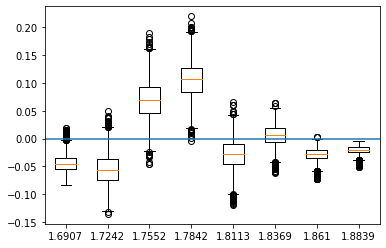

logistic_flat L:  146.91866805727048


In [13]:
##2b
def logit_link(x, params):
    # params: [beta1, beta2]
    nu = params[0]+params[1]*x
    return exp((nu))/(1+exp(nu))

logistic_flat_initial = [0,0]
logistic_flat_initial_inst = MCMC_Core.MCMC_MH(
                partial(logit_posterior_with_flat_prior, data=x_m_y),
                symmetric_proposal_placeholder,
                partial(normal_proposal_sampler, proposal_sigma_vec=[3, 3]),
                logistic_flat_initial)
logistic_flat_initial_inst.generate_samples(200000, print_iter_cycle=20000)
logistic_flat_diag = MCMC_Core.MCMC_Diag()
logistic_flat_diag.set_mc_sample_from_MCMC_instance(logistic_flat_initial_inst)
logistic_flat_diag.set_variable_names(["beta1", "beta2"])
logistic_flat_diag.burnin(20000)
logistic_flat_diag.thinning(40)
logistic_flat_diag.show_traceplot((1,2))
logistic_flat_diag.show_acf(30, (1,2))
logistic_flat_diag.show_hist((1,2))
logistic_flat_diag.print_summaries(3)


logistic_flat_LD50_samples = [[-x[0]/x[1]] for x in logistic_flat_diag.MC_sample]
logistic_flat_LD50_diag = MCMC_Core.MCMC_Diag()
logistic_flat_LD50_diag.set_mc_samples_from_list(logistic_flat_LD50_samples)
logistic_flat_LD50_diag.set_variable_names(["LD50"])
logistic_flat_LD50_diag.show_hist((1,1))

pi_plot(logistic_flat_diag.MC_sample, logit_link)
bayesian_residual_plot(logistic_flat_diag.MC_sample, logit_link)
print("logistic_flat L: ", loss_L_measure(logistic_flat_diag.MC_sample, logit_link, 10)) #144.67401288130463




We can see that fitting gets worse compared to the cloglog link model above on the fitted $pi$ plot and the residual plot.
The 'L' measure also grows, indicating worse fit than cloglog fit.

This result consists of the comparison in Q1, using frequentist's GLM fits.

### 2-(c) Powered logit link model

I think it is a little risky to use flat prior, cause I am not sure it yields a proper posterior.
We may check whether it is by calculating the marginal distribution, but let me skip it.

I use vague normal prior here. i.e. $[\beta_1, \beta_2, log(\alpha)] \sim N_3([0,0,0], diag(40^2, 20^2, 0.2^2))$.

Note that, $\lambda=log(\alpha)$ in the code. (I used the same notation in the separately attached note.)
I run a MCMC chain for $(\beta_1, \beta_2, \lambda)$, and get $\alpha$ samples from the $\lambda$ samples.

estimated running time:  0.0 min  5.702018737792969 sec
iteration 20000 / 200000
iteration 40000 / 200000
iteration 60000 / 200000
iteration 80000 / 200000
iteration 100000 / 200000
iteration 120000 / 200000
iteration 140000 / 200000
iteration 160000 / 200000
iteration 180000 / 200000
iteration 200000 / 200000  done! (elapsed time for execution:  0.0 min  5.477230548858643 sec)
acceptance rate:  0.0242


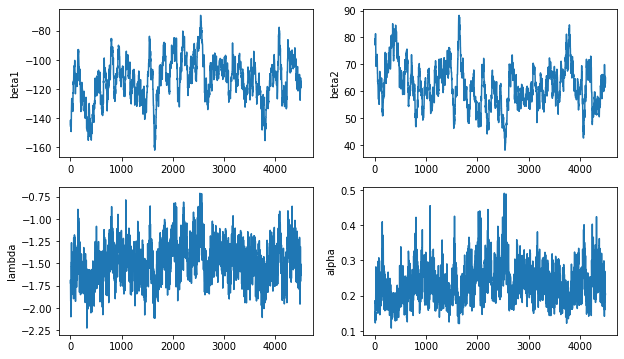

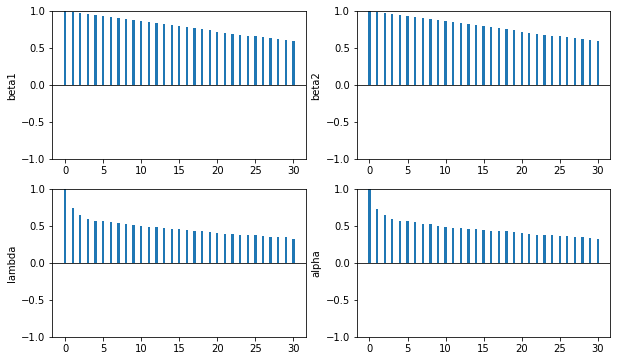

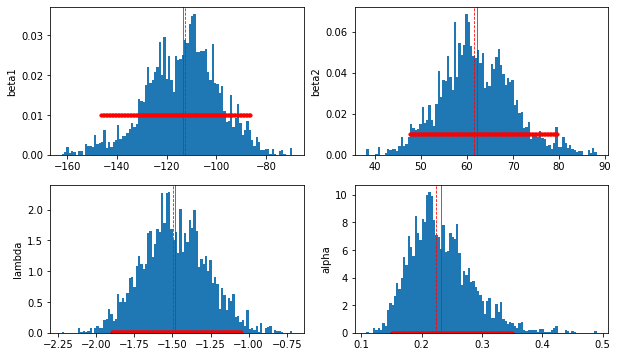

param 		 mean 	 var 	 95%CI
beta1 		 -113.487 	 217.292 	 [-146.322, -86.384]
beta2 		 62.106 	 63.278 	 [47.51, 79.633]
lambda 		 -1.484 	 0.046 	 [-1.893, -1.052]
alpha 		 0.232 	 0.003 	 [0.151, 0.349]


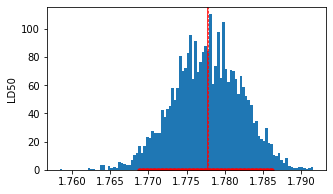

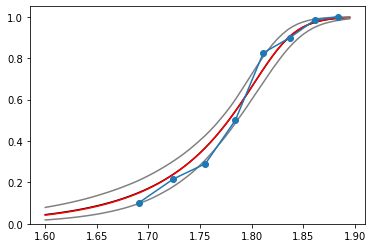

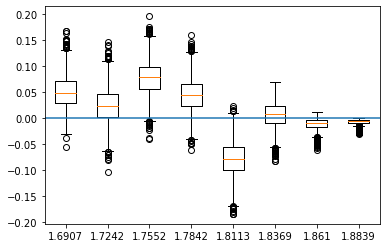

pw_logistic_normal L:  147.20727357412414


In [14]:
##2c
def pw_logit_link(x, params):
    # params: [beta1, beta2, lambda, alpha]
    nu = params[0]+params[1]*x
    return exp(params[3]*(nu))/(1+exp(nu))**params[3]

pw_logistic_normal_initial = [0,0,0]
pw_logistic_normal_initial_inst = MCMC_Core.MCMC_MH(
                partial(powered_logit_posterior_with_normal_prior, data=x_m_y, sigma1=40, sigma2=20, sigma_lambda=0.2),
                symmetric_proposal_placeholder,
                partial(normal_proposal_sampler, proposal_sigma_vec=[3, 3, 0.4]),
                pw_logistic_normal_initial)
pw_logistic_normal_initial_inst.generate_samples(200000, print_iter_cycle=20000)

pw_samples_appended = [smpl + [exp(smpl[2])] for smpl in pw_logistic_normal_initial_inst.MC_sample]

pw_logistic_normal_diag = MCMC_Core.MCMC_Diag()
pw_logistic_normal_diag.set_mc_samples_from_list(pw_samples_appended)
pw_logistic_normal_diag.set_variable_names(["beta1", "beta2", "lambda", "alpha"])
pw_logistic_normal_diag.burnin(20000)
pw_logistic_normal_diag.thinning(40)
pw_logistic_normal_diag.show_traceplot((2,2))
pw_logistic_normal_diag.show_acf(30, (2,2))
pw_logistic_normal_diag.show_hist((2,2))
pw_logistic_normal_diag.print_summaries(3)


pw_logistic_normal_LD50_samples = [[(log(0.5**(1/x[3])/(1-0.5**(1/x[3])))-x[0])/x[1]] for x in pw_logistic_normal_diag.MC_sample]
pw_logistic_normal_LD50_diag = MCMC_Core.MCMC_Diag()
pw_logistic_normal_LD50_diag.set_mc_samples_from_list(pw_logistic_normal_LD50_samples)
pw_logistic_normal_LD50_diag.set_variable_names(["LD50"])
pw_logistic_normal_LD50_diag.show_hist((1,1))

pi_plot(pw_logistic_normal_diag.MC_sample, pw_logit_link)
bayesian_residual_plot(pw_logistic_normal_diag.MC_sample, pw_logit_link)
print("pw_logistic_normal L: ", loss_L_measure(pw_logistic_normal_diag.MC_sample, pw_logit_link, 10)) # 144.06169963213338

Honestly speaking, MCMC convergence is not very good.
However, I think it is enough to draw some inference results that are accurate enough, cause the chains are not diverging at least.
Also note that almost all MCMC chains having shape parameter like $\alpha$ tend to be unstable.

Interestingly, $\pi$ fit plot and bayesian residual plot seem good.
They are very similar with cloglog model's.

However, the quadratic loss measure 'L' measure of this model is worse than cloglog model's as well as logistic model's.
Perhaps, it is because of higher variance of the posterior predictive distribution for $y$, coming from the additional parameter $\alpha$.


### LD50 summaries

In [19]:
print("cloglog_flat_prior")
cloglog_flat_LD50_diag.print_summaries(7)
print("cloglog_normal_prior")
cloglog_normal_LD50_diag.print_summaries(7)
print("logit_flat_prior")
logistic_flat_LD50_diag.print_summaries(7)
print("powered_logit_normal_prior")
pw_logistic_normal_LD50_diag.print_summaries(7)

cloglog_flat_prior
param 		 mean 	 var 	 95%CI
LD50 		 1.778883 	 1.52e-05 	 [1.7710012, 1.78633]
cloglog_normal_prior
param 		 mean 	 var 	 95%CI
LD50 		 1.7762685 	 1.85e-05 	 [1.7677328, 1.7843501]
logit_flat_prior
param 		 mean 	 var 	 95%CI
LD50 		 1.771793 	 1.5e-05 	 [1.7641031, 1.7794282]
powered_logit_normal_prior
param 		 mean 	 var 	 95%CI
LD50 		 1.7777237 	 2.03e-05 	 [1.768767, 1.7862427]


Again, sorry for badly adjustable column.

Posterior means are similar for all models.
The lengths of 95% credible interval are slightly different each other, but generally, we can say that they are almost similar.